<a href="https://colab.research.google.com/github/supunabeywickrama/my-colab-work/blob/main/Autoencoders_PCB_defect_anomaly_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:

!pip install torch torchvision opencv-python matplotlib scikit-learn

import os, glob, json, random, shutil, zipfile
from pathlib import Path
import numpy as np
import cv2
import torch, torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc, confusion_matrix, classification_report

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
SEED = 42
random.seed(SEED); np.random.seed(SEED); torch.manual_seed(SEED); torch.cuda.manual_seed_all(SEED)
print("Device:", DEVICE)


Device: cuda


In [2]:
ZIP_PATH = "/content/PCB defect.zip"  # <-- rename to your actual uploaded zip filename

# Extract to ./roboflow_export
dst = Path("roboflow_export")
dst.mkdir(exist_ok=True)
with zipfile.ZipFile(ZIP_PATH, 'r') as z:
    z.extractall(dst)
print("Unzipped to", dst.resolve())

# Quick peek at structure
for p in dst.glob("*"):
    print("[DIR]" if p.is_dir() else "[FILE]", p)


Unzipped to /content/roboflow_export
[DIR] roboflow_export/valid
[FILE] roboflow_export/README.dataset.txt
[FILE] roboflow_export/README.roboflow.txt
[DIR] roboflow_export/train
[FILE] roboflow_export/data.yaml


In [3]:
import json, shutil
from pathlib import Path
import random

SRC = Path("roboflow_export")
OUT = Path("project/data")
for p in (OUT/"train_normal", OUT/"test_normal", OUT/"test_anomaly"):
    p.mkdir(parents=True, exist_ok=True)

# 1) gather all images under train/ and valid/ (recursively)
IMG_EXTS = {".jpg",".jpeg",".png",".bmp",".tif",".tiff"}
def all_images(root):
    return [p for p in root.rglob("*") if p.suffix.lower() in IMG_EXTS]

train_imgs = all_images(SRC/"train")
valid_imgs = all_images(SRC/"valid")
imgs = train_imgs + valid_imgs
print(f"Found images: train={len(train_imgs)}, valid={len(valid_imgs)}, total={len(imgs)}")

# 2) given an image path, try to locate its label file(s) in common places
def find_label_files(img_path: Path):
    stem = img_path.stem
    cand = []
    # a) same folder
    cand += [img_path.with_suffix(".txt"), img_path.with_suffix(".json")]
    # b) YOLO-style sibling 'labels' folder
    if (img_path.parent.name == "images") and (img_path.parent.parent / "labels").exists():
        lab_dir = img_path.parent.parent / "labels"
        cand += [lab_dir / f"{stem}.txt", lab_dir / f"{stem}.json"]
    # c) generic 'labels' folder next to current folder
    if (img_path.parent.parent / "labels").exists():
        lab_dir = img_path.parent.parent / "labels"
        cand += [lab_dir / f"{stem}.txt", lab_dir / f"{stem}.json"]
    # d) sometimes Roboflow nests deeper; walk upwards a bit
    up1 = img_path.parent.parent
    up2 = up1.parent if up1 else None
    for base in [up1, up2]:
        if base and (base / "labels").exists():
            lab_dir = base / "labels"
            cand += [lab_dir / f"{stem}.txt", lab_dir / f"{stem}.json"]
    # keep only those that exist
    return [p for p in cand if p.exists()]

def txt_has_content(p: Path) -> bool:
    try:
        return p.read_text(encoding="utf-8").strip() != ""
    except Exception:
        return False

def json_has_annotations(p: Path) -> bool:
    try:
        data = json.load(open(p, "r", encoding="utf-8"))
        # common Roboflow JSON: {"annotations":[...]} or COCO-like
        if isinstance(data, dict):
            if "annotations" in data and isinstance(data["annotations"], list):
                return len(data["annotations"]) > 0
            if "objects" in data and isinstance(data["objects"], list):
                return len(data["objects"]) > 0
        # per-image JSON sometimes has {"labels":[...]} etc.
        for key in ["labels","bboxes","objects"]:
            if key in data and isinstance(data[key], list) and len(data[key])>0:
                return True
        return False
    except Exception:
        return False

def has_annotations(img_path: Path) -> bool:
    labs = find_label_files(img_path)
    for lp in labs:
        if lp.suffix.lower()==".txt" and txt_has_content(lp):
            return True
        if lp.suffix.lower()==".json" and json_has_annotations(lp):
            return True
    return False

# 3) split normals/anomalies; keep 20% of normals for test
random.seed(42)
random.shuffle(imgs)
normals, anomalies = [], []
for im in imgs:
    if has_annotations(im):
        anomalies.append(im)
    else:
        normals.append(im)

if len(normals)==0:
    raise RuntimeError("No normal images detected (images without labels). Check your export format or labeling.")

cut = max(1, int(len(normals)*0.8))
train_normals = normals[:cut]
test_normals  = normals[cut:]

# (Optional) Cap sizes for a super-fast run; comment these lines out to use full data
# train_normals = train_normals[:1000]
# test_normals  = test_normals[:200]
# anomalies     = anomalies[:500]

def copy_many(files, dst):
    for f in files:
        shutil.copy(f, dst)

copy_many(train_normals, OUT/"train_normal")
copy_many(test_normals,  OUT/"test_normal")
copy_many(anomalies,     OUT/"test_anomaly")

print(f"Train normals : {len(train_normals)}")
print(f"Test normals  : {len(test_normals)}")
print(f"Test anomalies: {len(anomalies)}")

# Quick sanity check: show a couple of sample paths
print("Sample train_normal:", train_normals[0] if train_normals else "None")
print("Sample test_anomaly:", anomalies[0] if anomalies else "None")


Found images: train=114, valid=28, total=142
Train normals : 113
Test normals  : 29
Test anomalies: 0
Sample train_normal: roboflow_export/train/images/WIN_20220330_16_10_14_Pro_jpg.rf.a173cff06e65280a0c52ce98d724a4fe.jpg
Sample test_anomaly: None


In [4]:
import torch, torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from pathlib import Path
import cv2, numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc, confusion_matrix, classification_report
import os, json

DEVICE   = "cuda" if torch.cuda.is_available() else "cpu"
IMG_SIZE = 128
BATCH    = 64

tfm = transforms.Compose([
    transforms.ToTensor(),                 # [0,1]
    transforms.Resize((IMG_SIZE, IMG_SIZE))
])

class ImageFolderNoLabel(Dataset):
    def __init__(self, folder, transform):
        self.paths = sorted([p for p in Path(folder).glob("*") if p.suffix.lower() in {".jpg",".jpeg",".png",".bmp",".tif",".tiff"}])
        self.transform = transform
    def __len__(self): return len(self.paths)
    def __getitem__(self, idx):
        p = self.paths[idx]
        img = cv2.imread(str(p), cv2.IMREAD_GRAYSCALE)  # use grayscale (change to COLOR + 3ch model if needed)
        if img is None: raise RuntimeError(f"Failed to read {p}")
        ten = self.transform(img)                       # [1,H,W]
        return ten, str(p)

DATA = Path("project/data")
train_ds = ImageFolderNoLabel(DATA/"train_normal", tfm)
val_ok_ds = ImageFolderNoLabel(DATA/"test_normal", tfm)
val_ng_ds = ImageFolderNoLabel(DATA/"test_anomaly", tfm)

train_loader  = DataLoader(train_ds, batch_size=BATCH, shuffle=True, num_workers=0)
val_ok_loader = DataLoader(val_ok_ds, batch_size=1, shuffle=False)
val_ng_loader = DataLoader(val_ng_ds, batch_size=1, shuffle=False)

len(train_ds), len(val_ok_ds), len(val_ng_ds)


(113, 29, 0)

In [5]:
class ConvAE(nn.Module):
    def __init__(self):
        super().__init__()
        self.enc = nn.Sequential(
            nn.Conv2d(1, 16, 3, 2, 1), nn.ReLU(),  # 64x64
            nn.Conv2d(16,32, 3, 2, 1), nn.ReLU(),  # 32x32
            nn.Conv2d(32,64, 3, 2, 1), nn.ReLU(),  # 16x16
            nn.Conv2d(64,128,3, 2, 1), nn.ReLU(),  # 8x8
        )
        self.dec = nn.Sequential(
            nn.ConvTranspose2d(128,64, 4, 2, 1), nn.ReLU(),  # 16x16
            nn.ConvTranspose2d(64, 32, 4, 2, 1), nn.ReLU(),  # 32x32
            nn.ConvTranspose2d(32, 16, 4, 2, 1), nn.ReLU(),  # 64x64
            nn.ConvTranspose2d(16,  1, 4, 2, 1), nn.Sigmoid()# 128x128
        )
    def forward(self, x): return self.dec(self.enc(x))

model = ConvAE().to(DEVICE)
opt   = torch.optim.Adam(model.parameters(), lr=1e-3)
crit  = nn.L1Loss()  # L1 works nicely for recon


In [6]:
EPOCHS = 20  # you can reduce to 12–15 for a faster test
for ep in range(1, EPOCHS+1):
    model.train()
    total=0
    for x,_ in train_loader:
        x = x.to(DEVICE)
        y = model(x)
        loss = crit(y, x)
        opt.zero_grad(); loss.backward(); opt.step()
        total += loss.item()*x.size(0)
    print(f"Epoch {ep:02d} | Train L1: {total/len(train_ds):.4f}")


Epoch 01 | Train L1: 0.1862
Epoch 02 | Train L1: 0.1861
Epoch 03 | Train L1: 0.1859
Epoch 04 | Train L1: 0.1856
Epoch 05 | Train L1: 0.1850
Epoch 06 | Train L1: 0.1838
Epoch 07 | Train L1: 0.1812
Epoch 08 | Train L1: 0.1761
Epoch 09 | Train L1: 0.1746
Epoch 10 | Train L1: 0.1719
Epoch 11 | Train L1: 0.1673
Epoch 12 | Train L1: 0.1623
Epoch 13 | Train L1: 0.1637
Epoch 14 | Train L1: 0.1583
Epoch 15 | Train L1: 0.1555
Epoch 16 | Train L1: 0.1543
Epoch 17 | Train L1: 0.1492
Epoch 18 | Train L1: 0.1474
Epoch 19 | Train L1: 0.1455
Epoch 20 | Train L1: 0.1431


In [7]:
@torch.no_grad()
def score_loader(loader):
    model.eval()
    scores, ims, recons = [], [], []
    for x,paths in loader:
        x = x.to(DEVICE)
        y = model(x)
        s = (x - y).abs().mean(dim=(1,2,3)).cpu().numpy()
        scores.extend(s.tolist())
        ims.append(x.cpu()); recons.append(y.cpu())
    return np.array(scores), (torch.cat(ims,0) if ims else None), (torch.cat(recons,0) if recons else None)

ok_scores, ok_x, ok_yhat = score_loader(val_ok_loader)
ng_scores, ng_x, ng_yhat = score_loader(val_ng_loader)

if len(ng_scores) == 0:
    # No labeled anomalies? Use percentile on normals
    T = float(np.percentile(ok_scores, 99.5))
    print("No anomalies found; using percentile threshold:", T)
else:
    scores = np.concatenate([ok_scores, ng_scores])
    labels = np.concatenate([np.zeros_like(ok_scores), np.ones_like(ng_scores)])

    fpr, tpr, thr = roc_curve(labels, scores)
    roc_auc = auc(fpr, tpr)
    print("ROC-AUC:", roc_auc)

    # Choose high-precision operating point (FPR≈1%)
    target_fpr = 0.01
    idx = np.where(fpr <= target_fpr)[0]
    T = float(thr[idx[-1]] if len(idx) else thr[np.argmax(tpr - fpr)])
    print("Chosen threshold:", T)

    pred = (scores >= T).astype(int)
    print(confusion_matrix(labels, pred))
    print(classification_report(labels, pred, target_names=["Normal","Anomaly"]))


No anomalies found; using percentile threshold: 0.1741331097483635


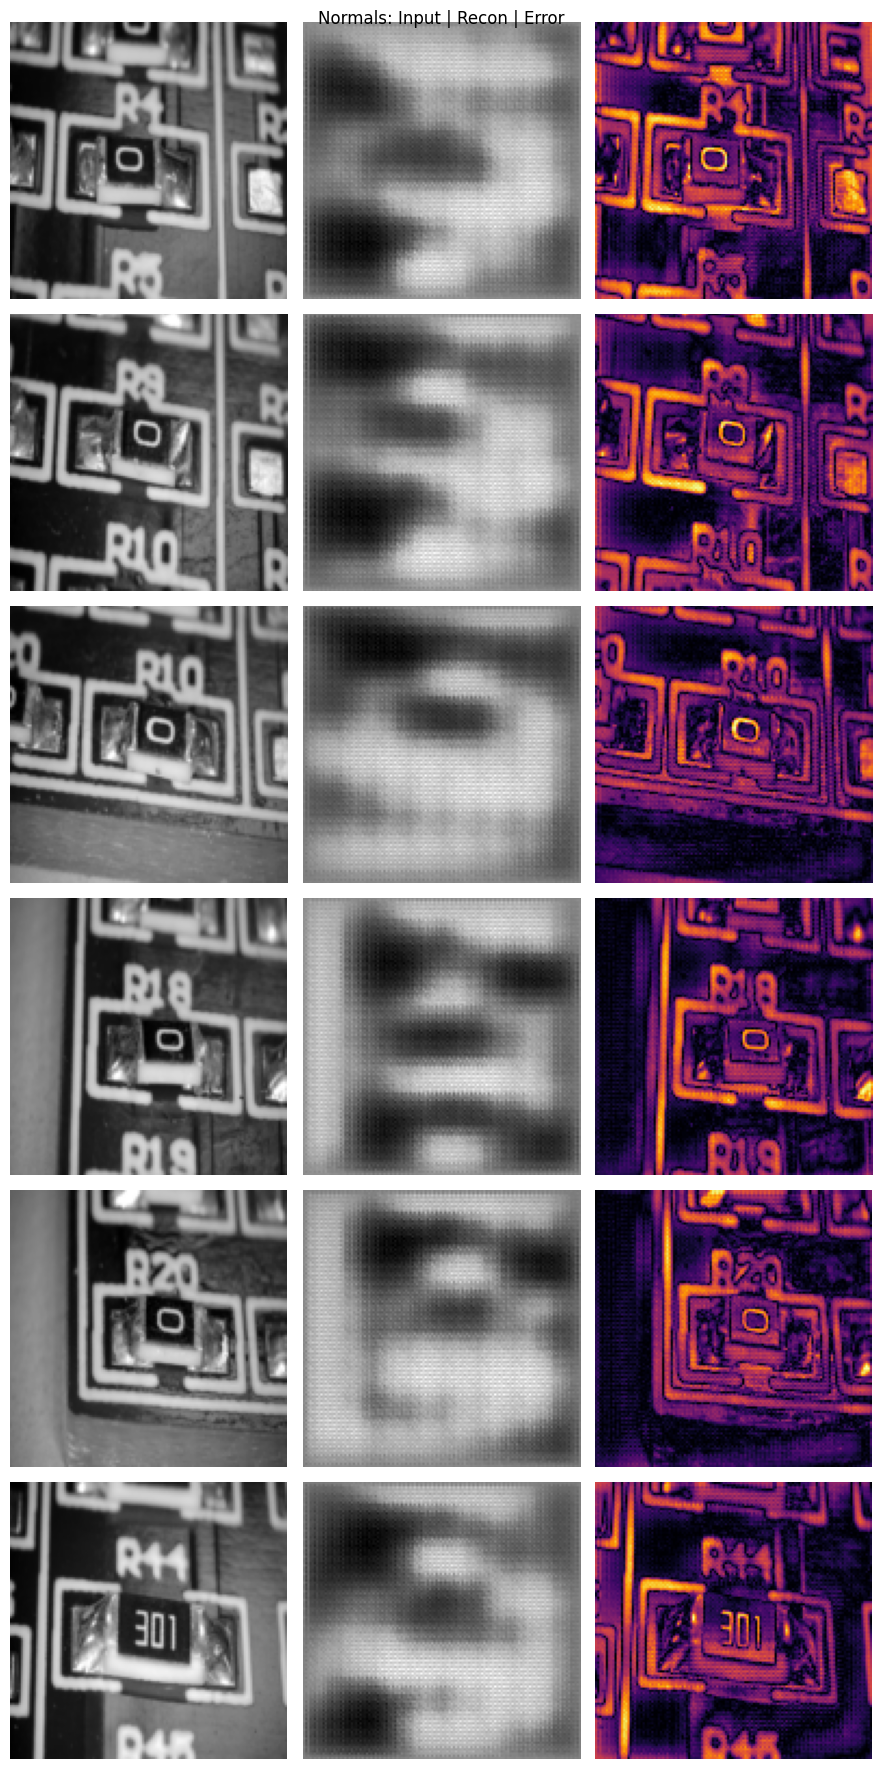

Nothing to show.


In [8]:
def show_triplet(x, yhat, n=6, title=""):
    if x is None or yhat is None or len(x)==0:
        print("Nothing to show."); return
    x = x[:n].squeeze().numpy()
    y = yhat[:n].squeeze().numpy()
    err = np.abs(x - y)
    plt.figure(figsize=(9,3*n))
    for i in range(min(n, len(x))):
        plt.subplot(n,3,3*i+1); plt.imshow(x[i], cmap="gray"); plt.axis('off')
        plt.subplot(n,3,3*i+2); plt.imshow(y[i], cmap="gray"); plt.axis('off')
        em = (err[i]-err[i].min())/(err[i].max()-err[i].min()+1e-8)
        plt.subplot(n,3,3*i+3); plt.imshow(em, cmap="inferno"); plt.axis('off')
    plt.suptitle(title); plt.tight_layout(); plt.show()

show_triplet(ok_x, ok_yhat, n=6, title="Normals: Input | Recon | Error")
show_triplet(ng_x, ng_yhat, n=6, title="Anomalies: Input | Recon | Error")


In [9]:
os.makedirs("artifacts", exist_ok=True)
torch.save(model.state_dict(), "artifacts/pcb_ae.pt")
with open("artifacts/threshold.json","w") as f:
    json.dump({"threshold": float(T), "img_size": IMG_SIZE, "grayscale": True}, f)
print("Saved: artifacts/pcb_ae.pt and artifacts/threshold.json")

@torch.no_grad()
def infer_bgr(image_bgr):
    """Input: cv2 BGR image. Output: verdict, score, binary mask, heatmap."""
    gray = cv2.cvtColor(image_bgr, cv2.COLOR_BGR2GRAY)
    ten = tfm(gray).unsqueeze(0).to(DEVICE)  # [1,1,H,W]
    y = model(ten)
    err = (ten - y).abs().squeeze().cpu().numpy()
    score = float(err.mean())
    verdict = "NG" if score >= T else "OK"
    em = (err - err.min())/(err.max()-err.min()+1e-8)
    mask = (em > np.clip(em.mean()+2*em.std(), 0.2, 0.9)).astype(np.uint8)*255
    return verdict, score, mask, em


Saved: artifacts/pcb_ae.pt and artifacts/threshold.json


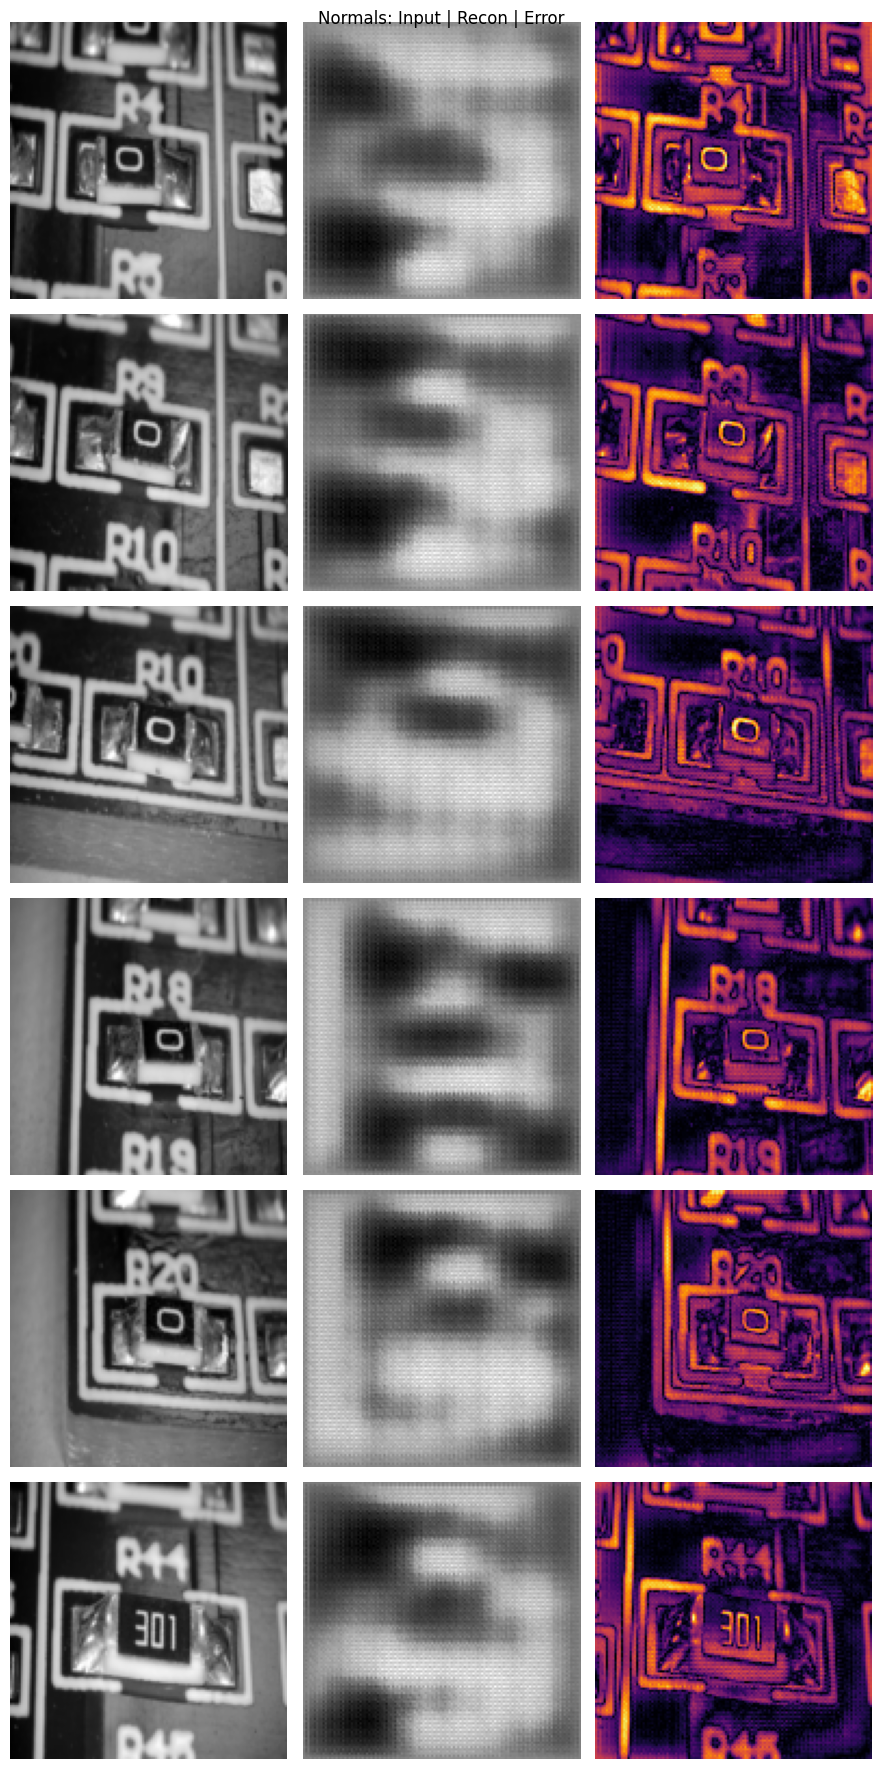

In [10]:
# Show normals even if anomalies are missing
def show_triplet_safe(x, yhat, n=6, title=""):
    if x is None or yhat is None or len(x)==0:
        print("Nothing to show (this split is empty)."); return
    x_ = x[:n].squeeze().numpy()
    y_ = yhat[:n].squeeze().numpy()
    err = (x_ - y_)
    import numpy as np, matplotlib.pyplot as plt
    plt.figure(figsize=(9,3*len(x_)))
    for i in range(len(x_)):
        plt.subplot(len(x_),3,3*i+1); plt.imshow(x_[i], cmap="gray"); plt.axis('off')
        plt.subplot(len(x_),3,3*i+2); plt.imshow(y_[i], cmap="gray"); plt.axis('off')
        em = (np.abs(err[i])-np.abs(err[i]).min())/(np.abs(err[i]).max()-np.abs(err[i]).min()+1e-8)
        plt.subplot(len(x_),3,3*i+3); plt.imshow(em, cmap="inferno"); plt.axis('off')
    plt.suptitle(title); plt.tight_layout(); plt.show()

show_triplet_safe(ok_x, ok_yhat, n=6, title="Normals: Input | Recon | Error")


Synthetic anomalies created in: project/data/test_anomaly count: 29
ROC-AUC (with synthetic anomalies): 0.6634958382877527
Chosen threshold: 0.17673668265342712
[[29  0]
 [24  5]]
              precision    recall  f1-score   support

      Normal       0.55      1.00      0.71        29
     Anomaly       1.00      0.17      0.29        29

    accuracy                           0.59        58
   macro avg       0.77      0.59      0.50        58
weighted avg       0.77      0.59      0.50        58



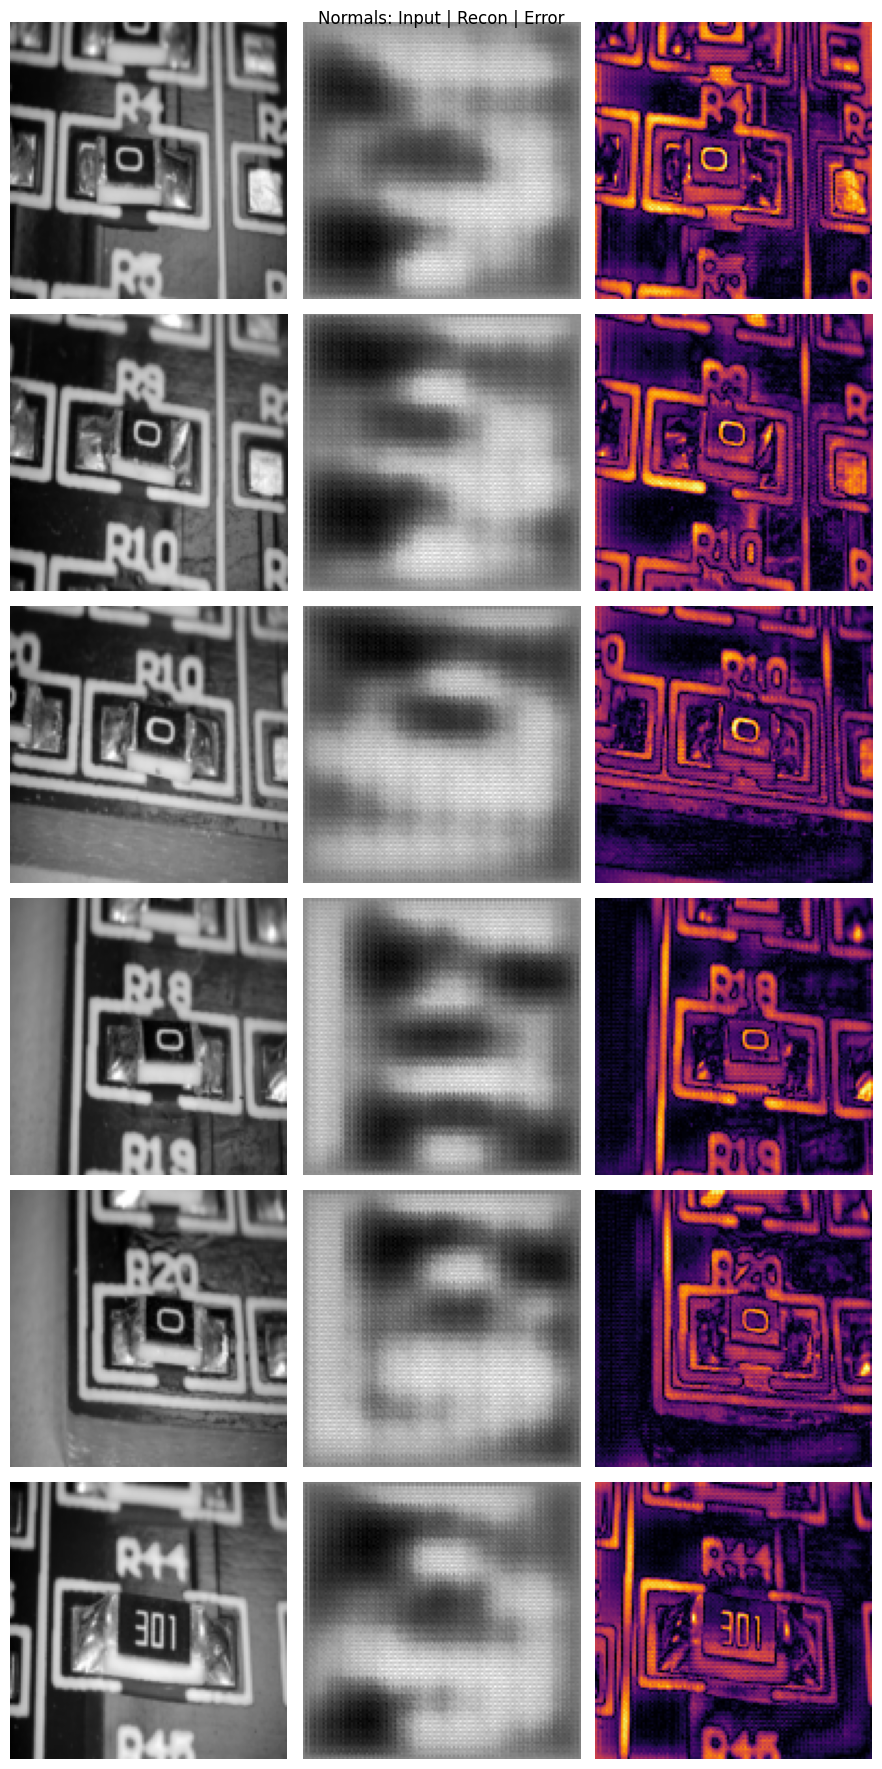

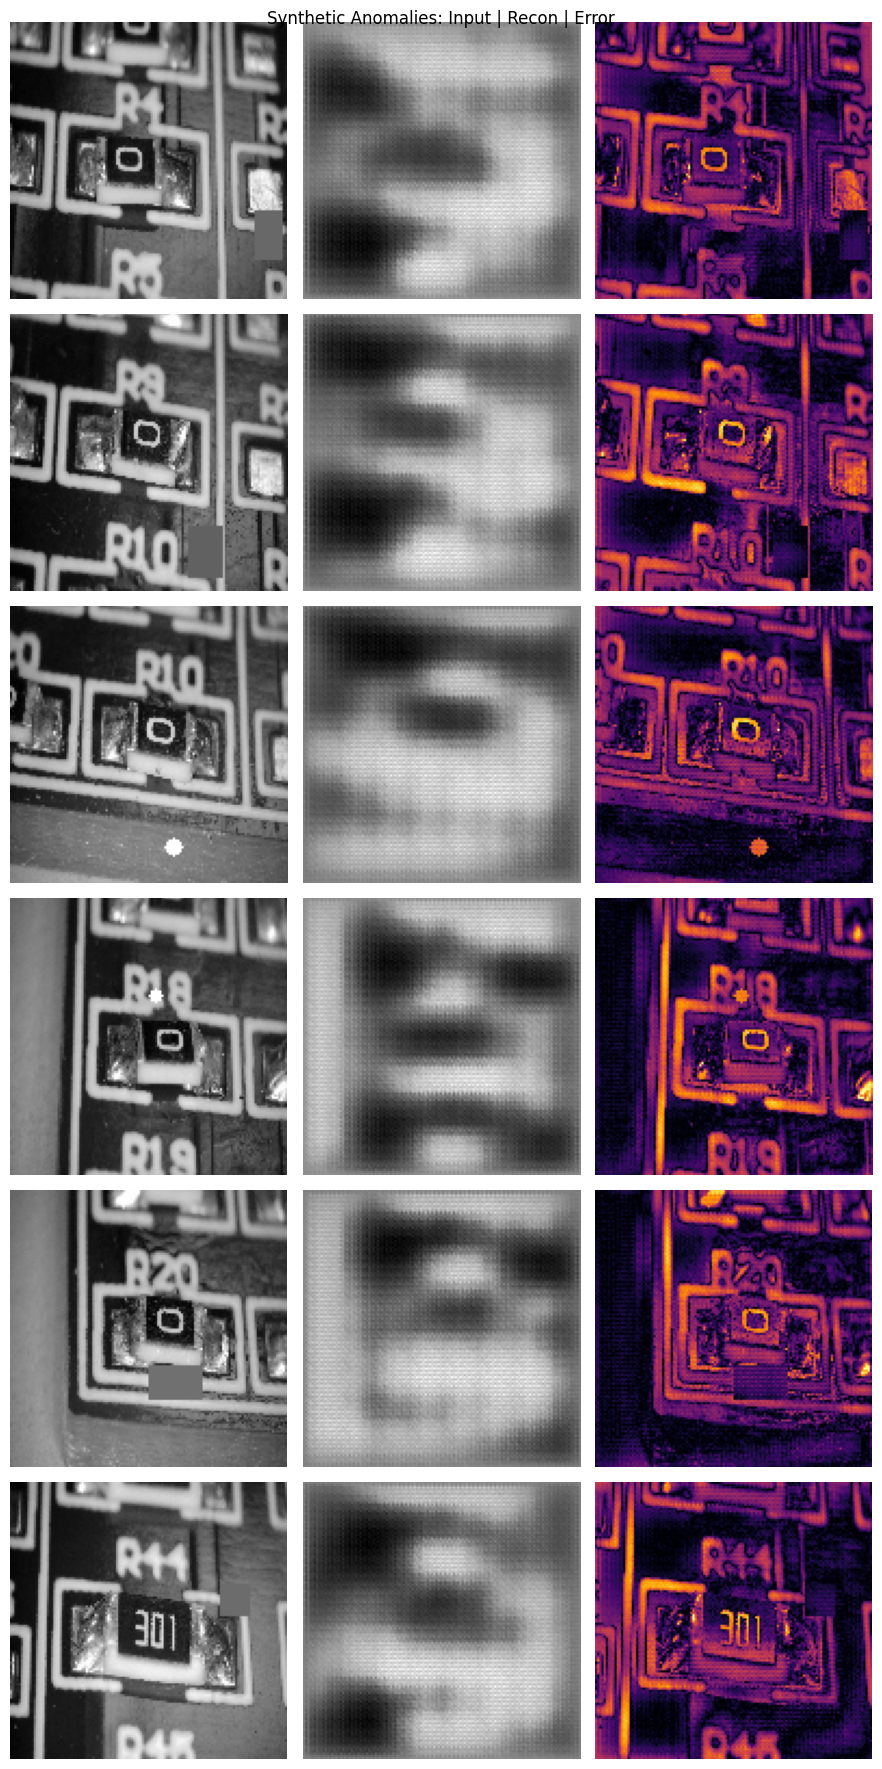

In [11]:
import cv2, numpy as np, random
from pathlib import Path
import shutil

DATA = Path("project/data")
SRC_OK = DATA/"test_normal"
DST_NG = DATA/"test_anomaly"
DST_NG.mkdir(parents=True, exist_ok=True)

# Clean old synthetic anomalies (optional)
for p in list(DST_NG.glob("_syn_*.*")):
    p.unlink()

def add_scribble(img):
    h,w = img.shape
    for _ in range(random.randint(1,3)):
        x1,y1 = random.randint(0,w-1), random.randint(0,h-1)
        x2,y2 = random.randint(0,w-1), random.randint(0,h-1)
        cv2.line(img, (x1,y1),(x2,y2), color=255, thickness=random.randint(1,3))
    return img

def add_blob(img):
    h,w = img.shape
    for _ in range(random.randint(1,2)):
        x,y = random.randint(0,w-1), random.randint(0,h-1)
        r = random.randint(max(2,w//40), max(4,w//20))
        cv2.circle(img, (x,y), r, color=255, thickness=-1)
    return img

def cutout(img):
    h,w = img.shape
    ch, cw = random.randint(h//10,h//5), random.randint(w//10,w//5)
    y = random.randint(0,h-ch); x = random.randint(0,w-cw)
    img[y:y+ch, x:x+cw] = int(img.mean())  # flat patch
    return img

ok_paths = sorted([p for p in SRC_OK.glob("*") if p.suffix.lower() in {".jpg",".jpeg",".png",".bmp",".tif",".tiff"}])

# create up to 60 synthetic anomalies
for i, p in enumerate(ok_paths[:60]):
    g = cv2.imread(str(p), cv2.IMREAD_GRAYSCALE)
    if g is None: continue
    g = cv2.resize(g, (IMG_SIZE, IMG_SIZE))
    mode = random.choice(["scribble","blob","cutout"])
    if mode=="scribble": g = add_scribble(g)
    elif mode=="blob":   g = add_blob(g)
    else:                g = cutout(g)
    out = DST_NG/f"_syn_{i:03d}.png"
    cv2.imwrite(str(out), g)

print("Synthetic anomalies created in:", DST_NG, "count:", len(list(DST_NG.glob('_syn_*.png'))))

# ---- RELOAD VAL LOADERS & RESCORE ----
val_ok_ds = ImageFolderNoLabel(DATA/"test_normal", tfm)
val_ng_ds = ImageFolderNoLabel(DATA/"test_anomaly", tfm)
val_ok_loader = DataLoader(val_ok_ds, batch_size=1, shuffle=False)
val_ng_loader = DataLoader(val_ng_ds, batch_size=1, shuffle=False)

ok_scores, ok_x, ok_yhat = score_loader(val_ok_loader)
ng_scores, ng_x, ng_yhat = score_loader(val_ng_loader)

from sklearn.metrics import roc_curve, auc, confusion_matrix, classification_report
scores = np.concatenate([ok_scores, ng_scores])
labels = np.concatenate([np.zeros_like(ok_scores), np.ones_like(ng_scores)])

fpr, tpr, thr = roc_curve(labels, scores)
roc_auc = auc(fpr, tpr)
print("ROC-AUC (with synthetic anomalies):", roc_auc)

target_fpr = 0.01
idx = np.where(fpr <= target_fpr)[0]
T = float(thr[idx[-1]] if len(idx) else thr[np.argmax(tpr - fpr)])
print("Chosen threshold:", T)

pred = (scores >= T).astype(int)
print(confusion_matrix(labels, pred))
print(classification_report(labels, pred, target_names=["Normal","Anomaly"]))

# visualize both splits now
show_triplet_safe(ok_x, ok_yhat, n=6, title="Normals: Input | Recon | Error")
show_triplet_safe(ng_x, ng_yhat, n=6, title="Synthetic Anomalies: Input | Recon | Error")


In [12]:
from pathlib import Path
DATA = Path("project/data")
def count(folder):
    return len([p for p in (DATA/folder).glob("*") if p.suffix.lower() in {".jpg",".jpeg",".png",".bmp",".tif",".tiff"}])

print("train_normal :", count("train_normal"))
print("test_normal  :", count("test_normal"))
print("test_anomaly :", count("test_anomaly"))

print("Example normal:", next((DATA/"test_normal").glob("*"), "None"))
print("Example anomaly:", next((DATA/"test_anomaly").glob("*"), "None"))


train_normal : 113
test_normal  : 29
test_anomaly : 29
Example normal: project/data/test_normal/WIN_20220330_13_22_42_Pro_jpg.rf.8d7a4889f90668aa3d65b89db9f10b60.jpg
Example anomaly: project/data/test_anomaly/_syn_002.png
